**EDA (Exploratory Data Analysis)**

We perform EDA to better understand the data from the Abstract of the arXiv at hand and make informed decisions while training and testing. 

Package Installation

In [1]:
!pip install kaggle

Imports

In [2]:
import tensorflow as tf
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.feature_extraction.text import CountVectorizer
import random
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import collections
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import nltk
from textblob import TextBlob

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Helper Functions

These helper functions are later utilized in different positions in the code

In [4]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [5]:
def get_top_n_words_without_stopwords(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [6]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [7]:
def get_top_n_bigram_without_stopwords(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [8]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [9]:
def get_top_n_trigram_without_stopwords(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Loading the arXiv Dataset

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
!kaggle datasets download -d Cornell-University/arxiv

 99% 1.03G/1.04G [00:11<00:00, 93.4MB/s]
100% 1.04G/1.04G [00:11<00:00, 98.1MB/s]


In [12]:
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!unzip /content/arxiv.zip

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [14]:
data_file = '/content/arxiv-metadata-oai-snapshot.json'

In [15]:
def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

Listing all Categories in cat_map

In [16]:
cat_map =      {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

Data Wrangling for 5 Years Data

In [17]:
titles = []
abstracts = []
categories = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(cat_map.keys())).flatten()

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    try:
        try:
            year = int(paper_dict.get('journal-ref')[-4:])    ### Example Format: "Phys.Rev.D76:013009,2007"
        except:
            year = int(paper_dict.get('journal-ref')[-5:-1])    ### Example Format: "Phys.Rev.D76:013009,(2007)"

        if category in paper_categories and 2018<year<2022:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
            categories.append(paper_dict.get('categories'))
    except:
        pass 

len(titles), len(abstracts), len(categories)

0it [00:00, ?it/s]

(41027, 41027, 41027)

In [18]:
df_5years = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'categories': categories
})
df_5years.head(5)

,title,abstract,categories
0,Bohmian Mechanics at Space-Time Singularities....,We develop an extension of Bohmian mechanics...,quant-ph
1,On the derivation of exact eigenstates of the ...,We construct the states that are invariant u...,quant-ph
2,Weight Reduction for Mod l Bianchi Modular Forms,Let K be an imaginary quadratic field with c...,math.NT
3,Lawson Method for Obtaining Wave Functions and...,Lawson has shown that one can obtain sensibl...,nucl-th
4,Exact results for the Wigner transform phase s...,Closed form analytical expressions are obtai...,physics.atom-ph


In [19]:
df_5years['abstract'] = df_5years['abstract'].apply(lambda x: x.replace("\n",""))
df_5years['abstract'] = df_5years['abstract'].apply(lambda x: x.strip())
df_5years['text'] = df_5years['title'] + '. ' + df_5years['abstract']

In [20]:
df_5years = df_5years[["text","categories"]]
df_5years

,text,categories
0,Bohmian Mechanics at Space-Time Singularities....,quant-ph
1,On the derivation of exact eigenstates of the ...,quant-ph
2,Weight Reduction for Mod l Bianchi Modular For...,math.NT
3,Lawson Method for Obtaining Wave Functions and...,nucl-th
4,Exact results for the Wigner transform phase s...,physics.atom-ph
...,...,...
41022,Constant of Motion for several one-dimensional...,physics.class-ph
41023,Activity ageing in growing networks. We presen...,physics.soc-ph
41024,Simple computer model for the quantum Zeno eff...,quant-ph
41025,Alternative Derivation of the Hu-Paz-Zhang Mas...,quant-ph


Data Wrangling for 10 Years Data

In [21]:
titles = []
abstracts = []
categories = []

# Consider all categories in the `category_map` to be used during training and prediction
paper_categories = np.array(list(cat_map.keys())).flatten()

metadata = get_metadata()
for paper in tqdm(metadata):
    paper_dict = json.loads(paper)
    category = paper_dict.get('categories')
    try:
        try:
            year = int(paper_dict.get('journal-ref')[-4:])    ### Example Format: "Phys.Rev.D76:013009,2007"
        except:
            year = int(paper_dict.get('journal-ref')[-5:-1])    ### Example Format: "Phys.Rev.D76:013009,(2007)"

        if category in paper_categories and 2013<year<2022:
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
            categories.append(paper_dict.get('categories'))
    except:
        pass 

len(titles), len(abstracts), len(categories)

0it [00:00, ?it/s]

(102970, 102970, 102970)

In [22]:
df_10years = pd.DataFrame({
    'title': titles,
    'abstract': abstracts,
    'categories': categories
})
df_10years.head(5)

,title,abstract,categories
0,On the Cohomological Derivation of Yang-Mills ...,We present a brief review of the cohomologic...,physics.gen-ph
1,Bohmian Mechanics at Space-Time Singularities....,We develop an extension of Bohmian mechanics...,quant-ph
2,A Procedure to Solve the Eigen Solution to Dir...,"In this paper, we provide a procedure to sol...",physics.gen-ph
3,What happens to geometric phase when spin-orbi...,Spin-orbit interaction lifts accidental band...,cond-mat.other
4,Functions of State for Spinor Gas in General R...,The energy momentum tensor of perfect fluid ...,physics.gen-ph


In [23]:
df_10years['abstract'] = df_10years['abstract'].apply(lambda x: x.replace("\n",""))
df_10years['abstract'] = df_10years['abstract'].apply(lambda x: x.strip())
df_10years['text'] = df_10years['title'] + '. ' + df_10years['abstract']

In [24]:
df_10years = df_10years[["text","categories"]]
df_10years

,text,categories
0,On the Cohomological Derivation of Yang-Mills ...,physics.gen-ph
1,Bohmian Mechanics at Space-Time Singularities....,quant-ph
2,A Procedure to Solve the Eigen Solution to Dir...,physics.gen-ph
3,What happens to geometric phase when spin-orbi...,cond-mat.other
4,Functions of State for Spinor Gas in General R...,physics.gen-ph
...,...,...
102965,Complementarity and the nature of uncertainty ...,quant-ph
102966,Alternative Derivation of the Hu-Paz-Zhang Mas...,quant-ph
102967,Guiding Neutral Atoms with a Wire. We demonstr...,quant-ph
102968,Limits for entanglement measures. We show that...,quant-ph


Encoding Categorical Values

In [25]:
label_encoder = LabelEncoder()
label_encoder.fit(df_10years['categories'])

LabelEncoder()

In [26]:
df_5years['categories_encoded'] = df_5years['categories'].apply(lambda x: label_encoder.transform([x])[0])
df_10years['categories_encoded'] = df_10years['categories'].apply(lambda x: label_encoder.transform([x])[0])

# **EDA for 5 Years Data**




In [27]:
df_5years.info()  # 1) A concise summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41027 entries, 0 to 41026
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                41027 non-null  object
 1   categories          41027 non-null  object
 2   categories_encoded  41027 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 961.7+ KB


In [28]:
df_5years.dtypes  # 2) To understand the datatypes of the different columns in the dataframe

text                  object
categories            object
categories_encoded     int64
dtype: object

In [29]:
df_5years.describe()   # 3) Used to generated a descriptive statistics of the dataframe

,categories_encoded
count,41027.000000
mean,55.525215
std,50.342581
min,0.000000
25%,9.000000
50%,44.000000
75%,102.000000
max,146.000000


In [30]:
df_5years.nunique()  # 4) Count number of distinct elements in specified axis.

text                  41027
categories              146
categories_encoded      146
dtype: int64

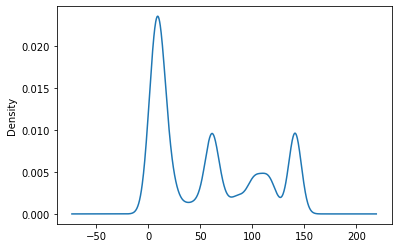

In [31]:
df_5years.categories_encoded.plot.kde()  # 5) To make a simple plot of the dataframe

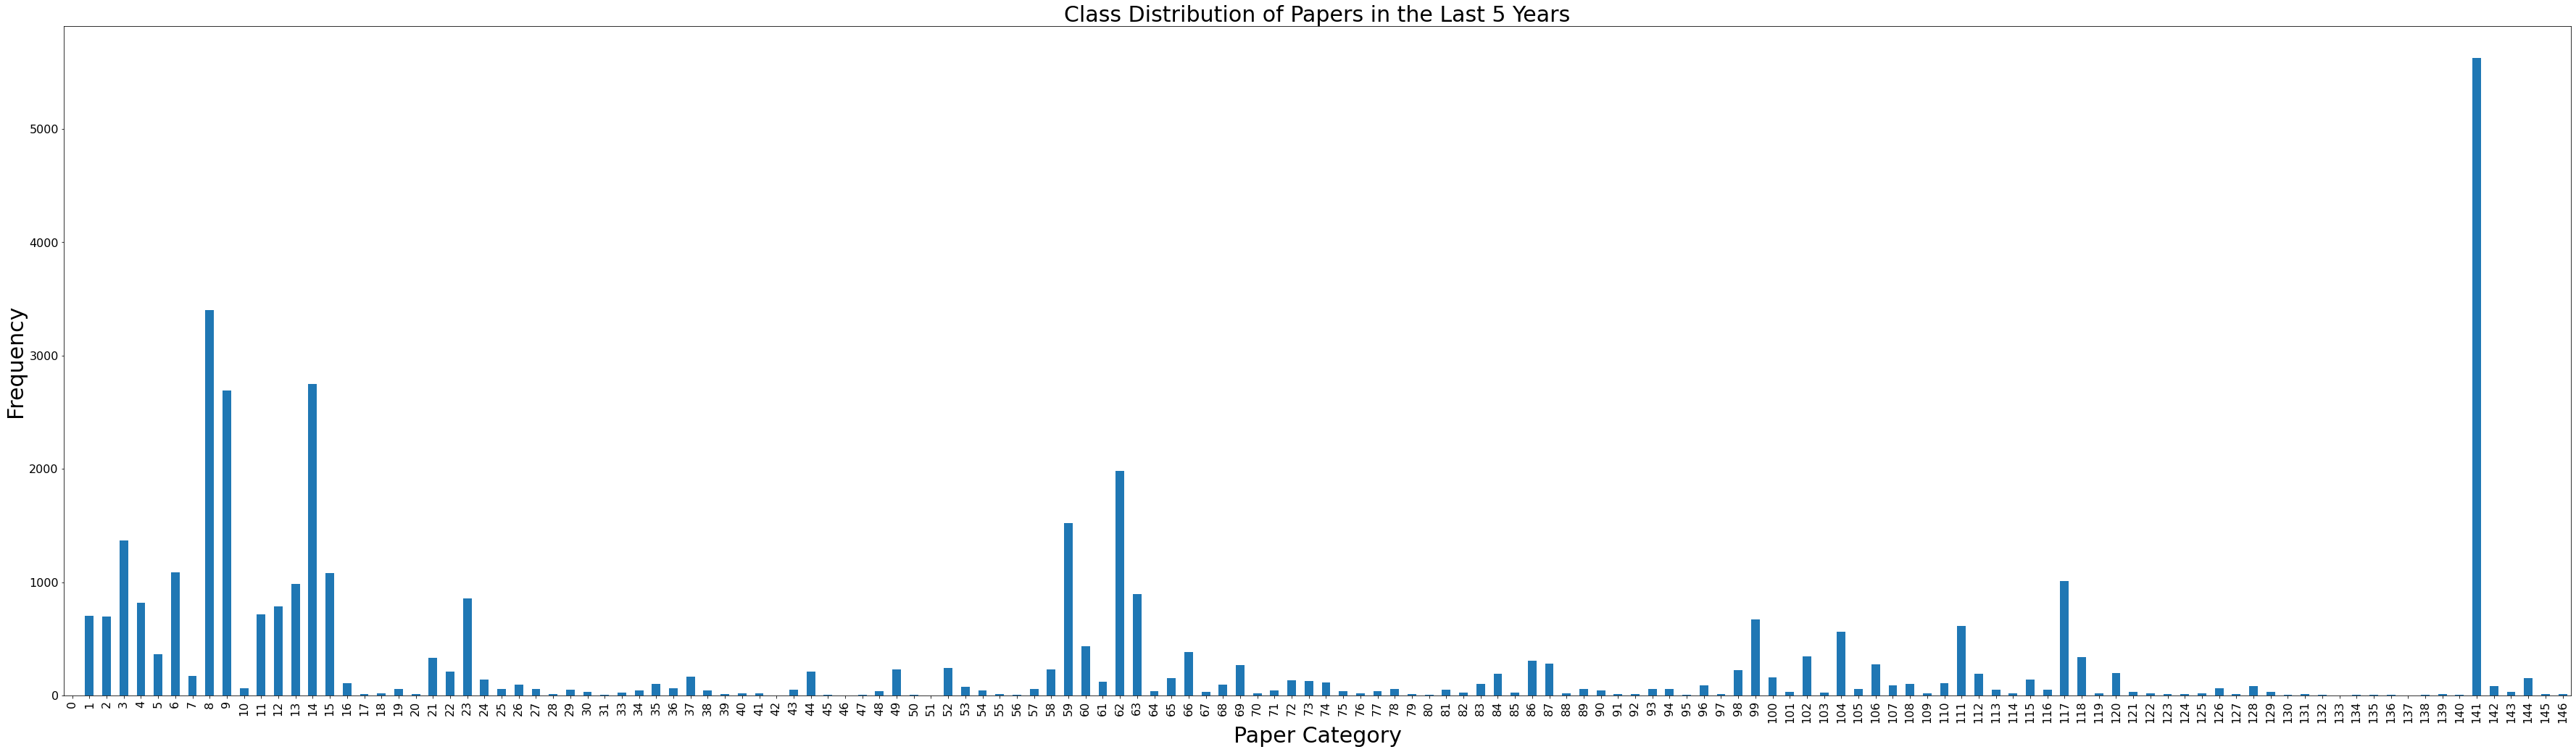

In [32]:
# 6) Class Distribution Plot
# Plots the frequency distribution of each label/category to which the Abstract of a publication belongs
ax = df_5years.groupby('categories_encoded').count()["categories"].plot(kind='bar', figsize=(62, 17), title="Class Distribution of Papers in the Last 5 Years", fontsize=16)
ax.axes.title.set_size(30)
ax.set_xlabel("Paper Category", fontsize = 30)
ax.set_ylabel("Frequency", fontsize = 30)
plt.show()

7) WordCloud - 5 Years Data

In [33]:
text = df_5years.text.values
word_cloud_text = (" ").join(text)

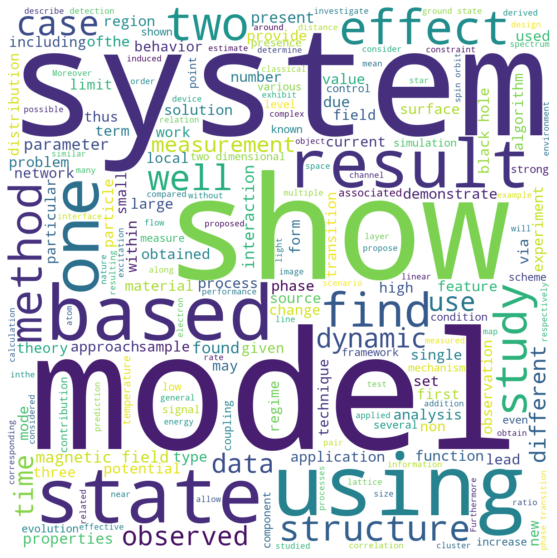

In [34]:
# Word Cloud to visually describe some of the commonly used words in publications
wordcloud = WordCloud(width = 1200, height = 1200, background_color ='white', stopwords = set(STOPWORDS), min_font_size = 10).generate(word_cloud_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

8) Top Unigrams

With Stopwords

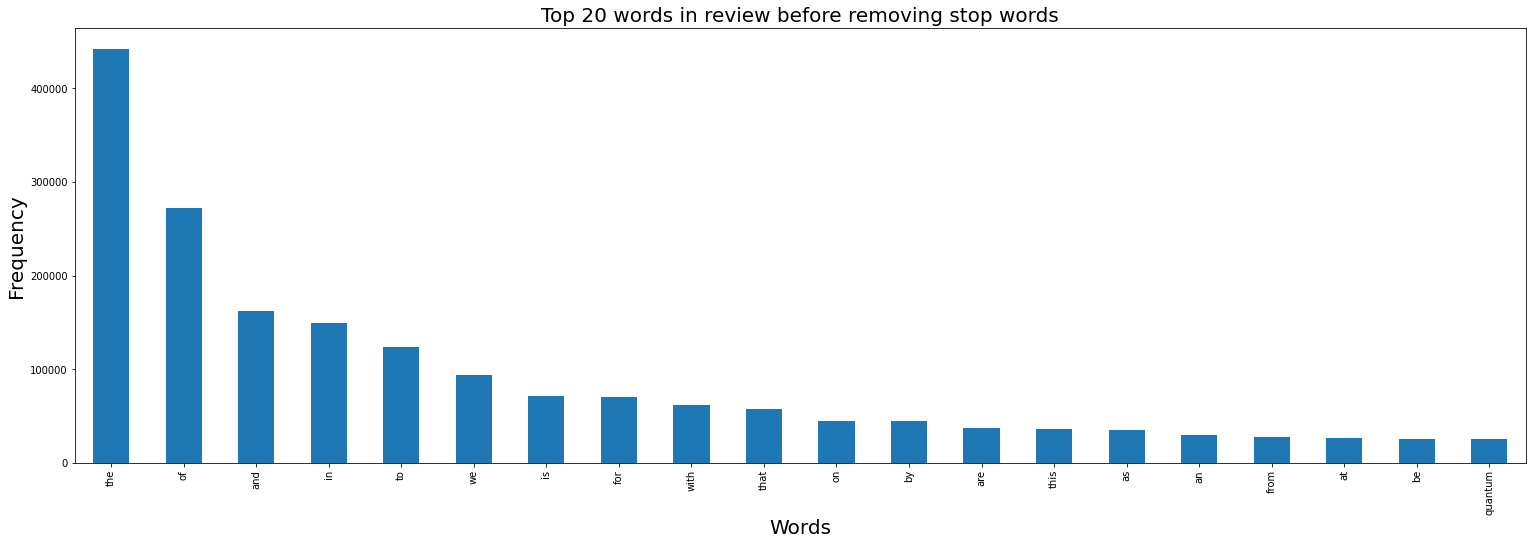

In [35]:
common_words = get_top_n_words(df_5years['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df1.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 words in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

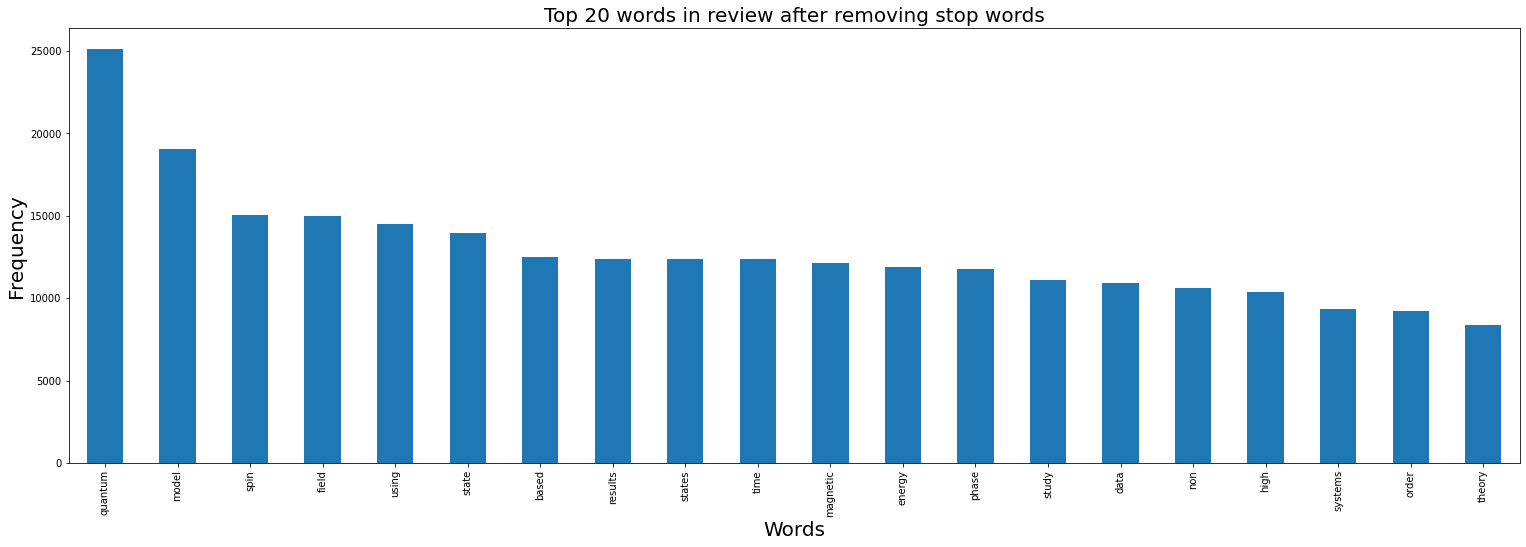

In [36]:
common_words = get_top_n_words_without_stopwords(df_5years['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 words in review after removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

9) Top Bigrams

With Stopwords

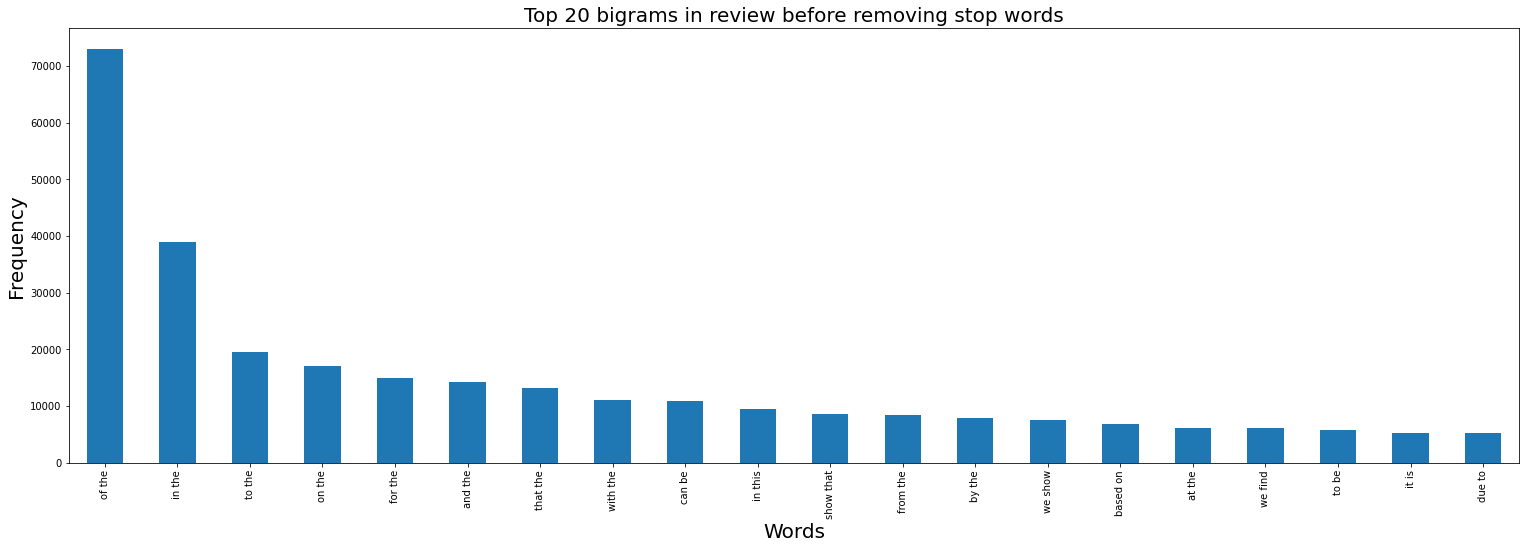

In [37]:
common_words = get_top_n_bigram(df_5years['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 bigrams in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

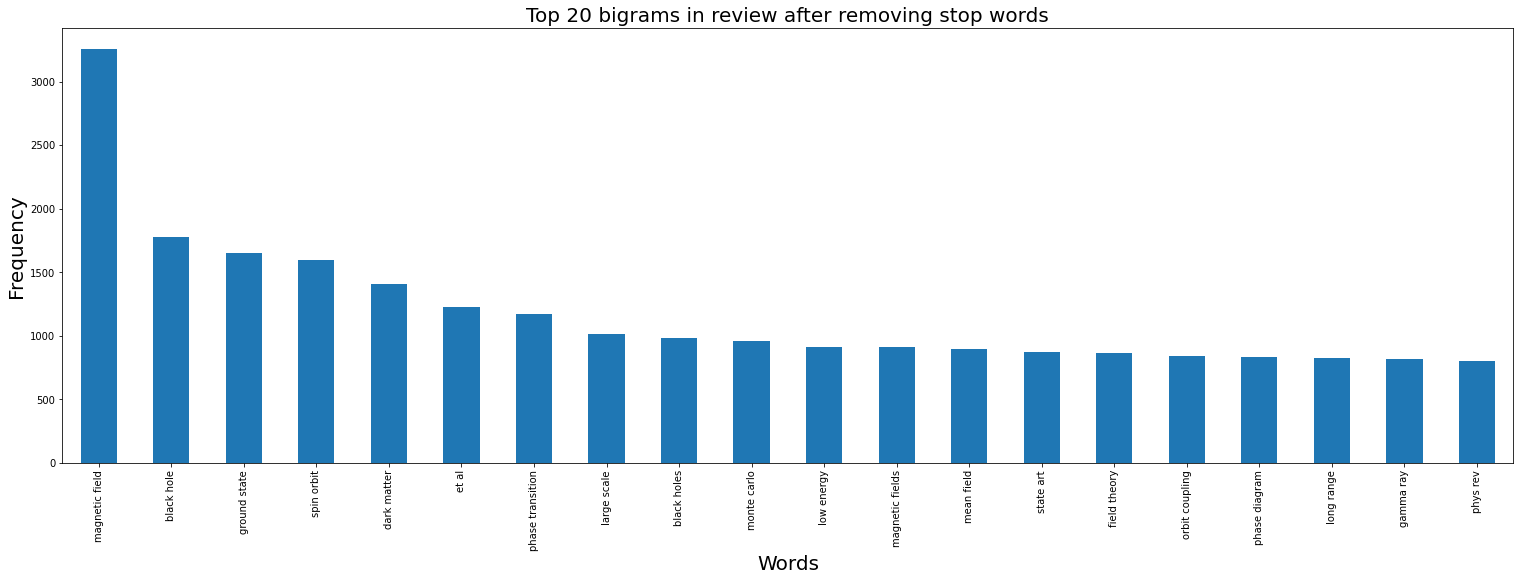

In [38]:
common_words = get_top_n_bigram_without_stopwords(df_5years['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df4.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 bigrams in review after removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

10) Top Trigrams

With Stopwords

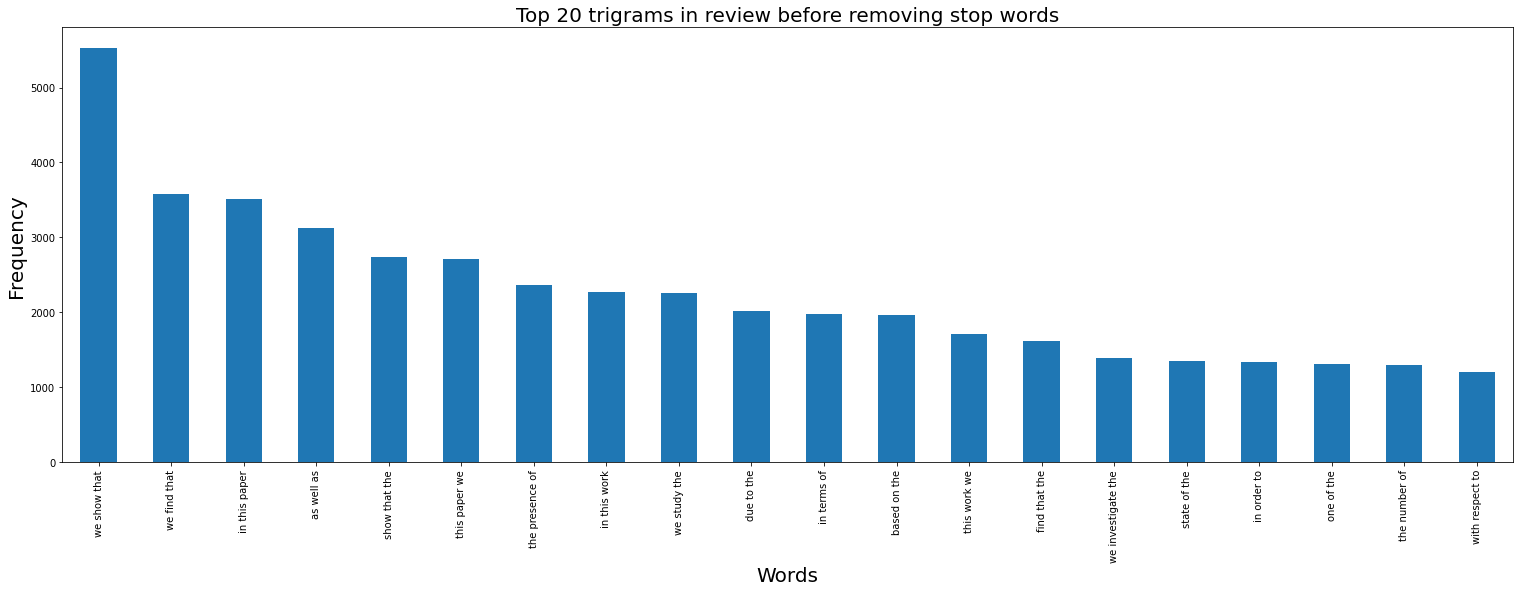

In [39]:
common_words = get_top_n_trigram(df_5years['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df5.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 trigrams in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

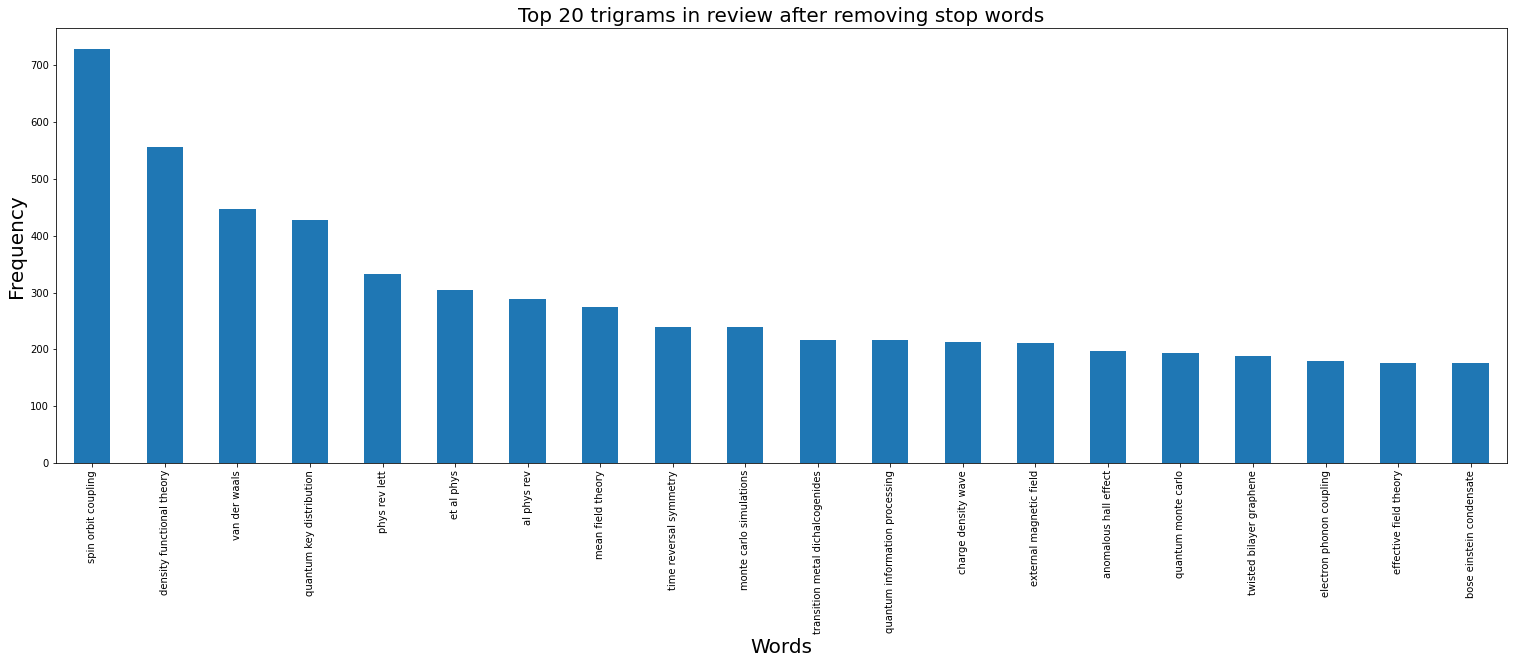

In [40]:
common_words = get_top_n_trigram_without_stopwords(df_5years['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df6.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 trigrams in review after removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

11) Top part-of-speech Tags

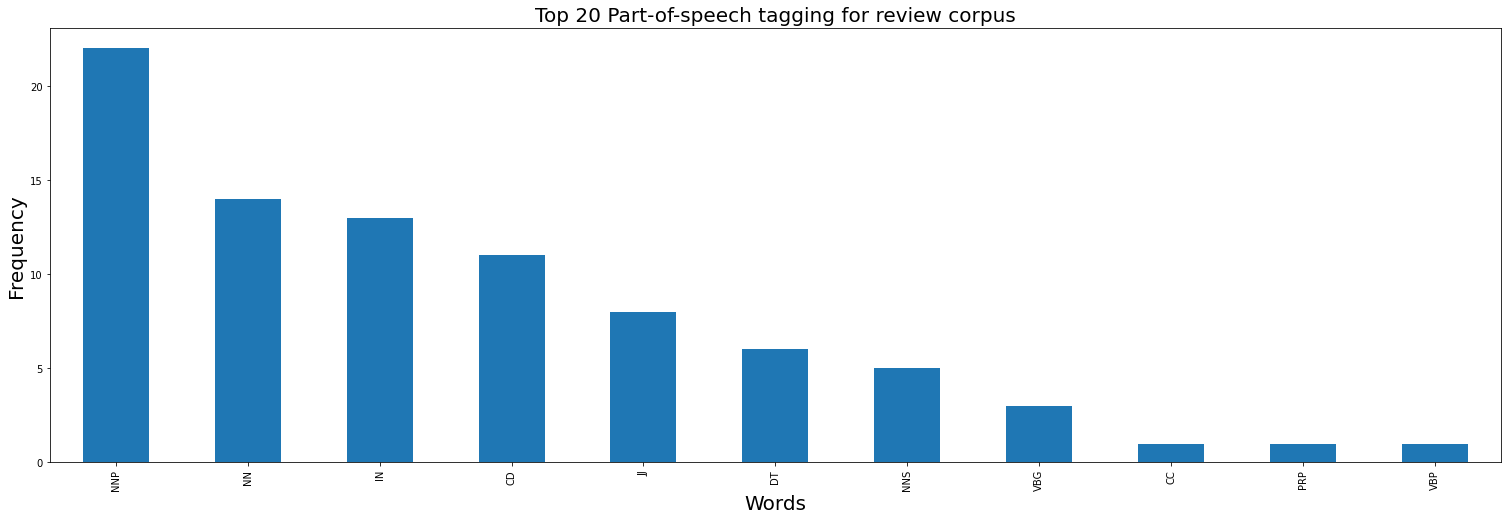

In [41]:
blob = TextBlob(str(df_5years['text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
ax = pos_df.plot(figsize=(26, 8), kind='bar', title='Top 20 Part-of-speech tagging for review corpus')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

# EDA for 10 Years Data

In [42]:
df_10years.info()  # 1) A concise summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102970 entries, 0 to 102969
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   text                102970 non-null  object
 1   categories          102970 non-null  object
 2   categories_encoded  102970 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [43]:
df_10years.dtypes  # 2) To understand the datatypes of the different columns in the dataframe

text                  object
categories            object
categories_encoded     int64
dtype: object

In [44]:
df_10years.describe()   # 3) Used to generated a descriptive statistics of the dataframe

,categories_encoded
count,102970.000000
mean,53.764844
std,50.307368
min,0.000000
25%,9.000000
50%,26.000000
75%,100.000000
max,146.000000


In [45]:
df_10years.nunique()  # 4) Count number of distinct elements in specified axis.

text                  102969
categories               147
categories_encoded       147
dtype: int64

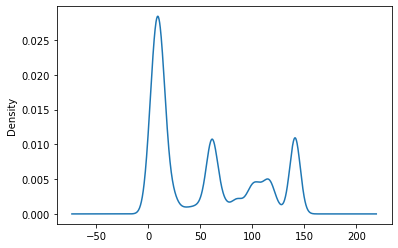

In [46]:
df_10years.categories_encoded.plot.kde()  # 5) To make a simple plot of the dataframe

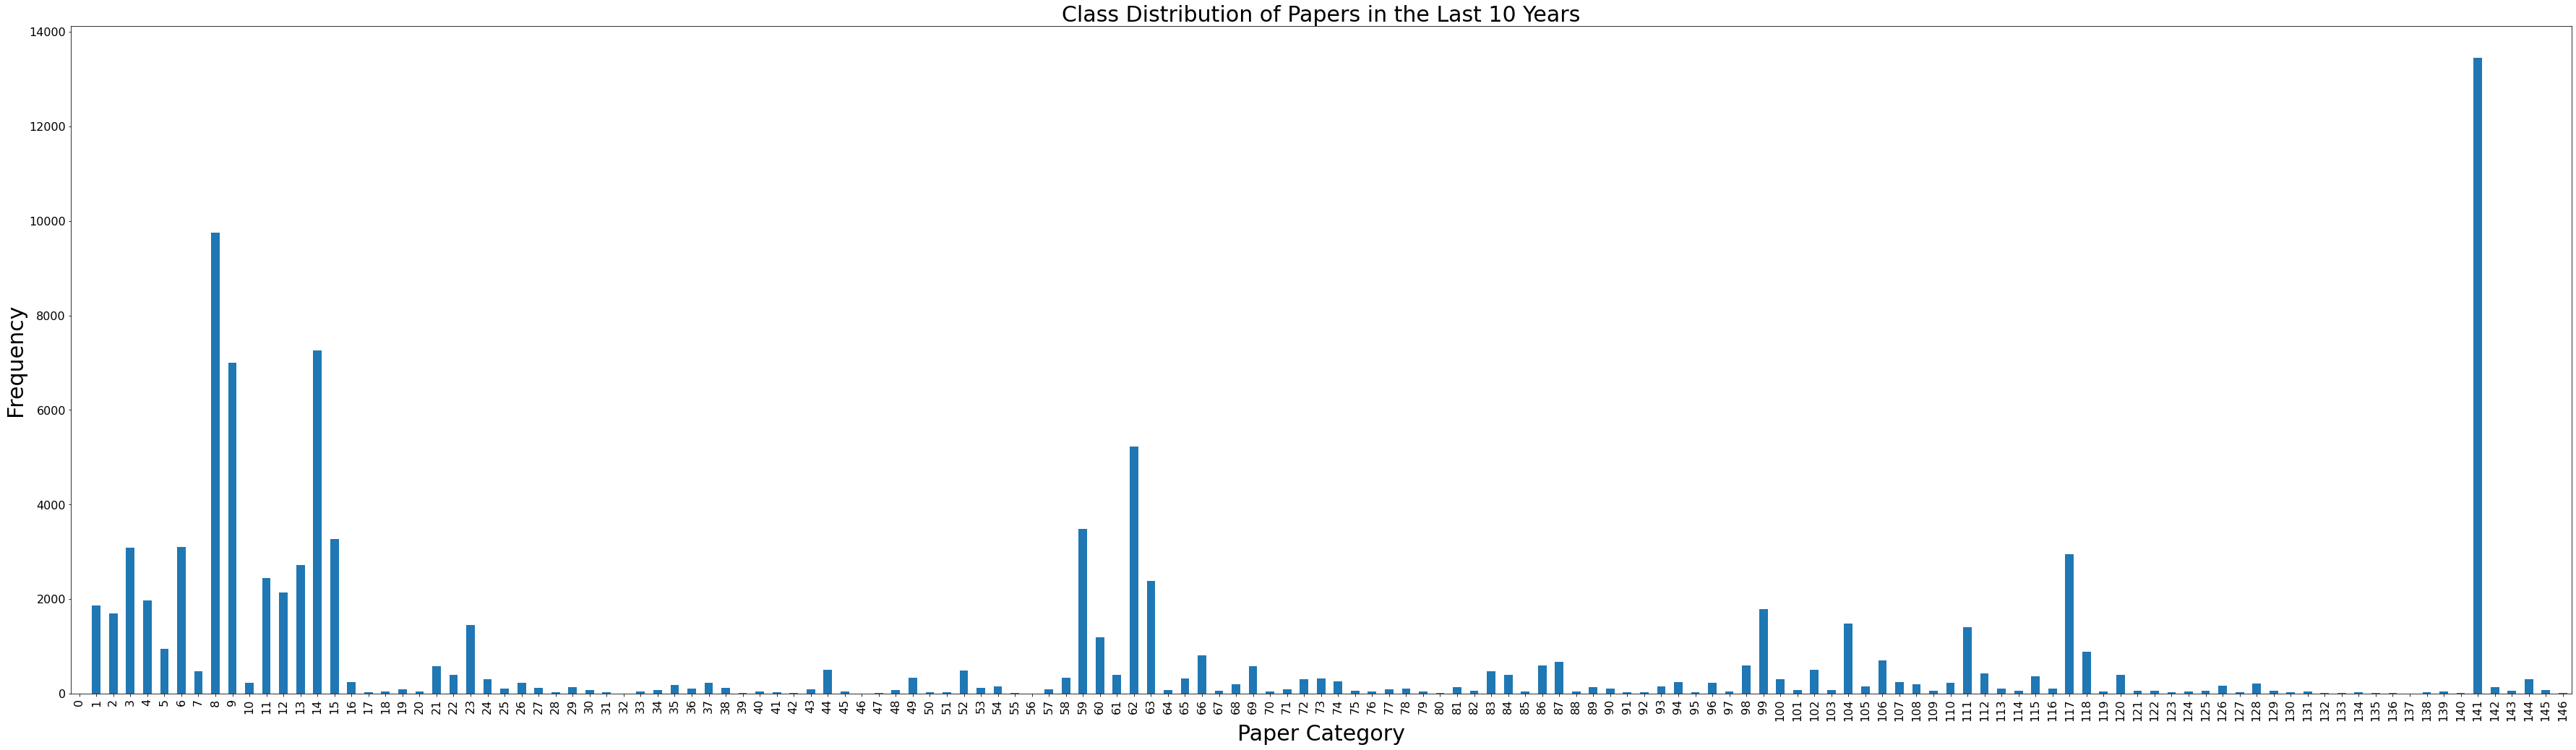

In [47]:
# 6) Class Distribution Plot
# Plots the frequency distribution of each label/category to which the Abstract of a publication belongs
ax = df_10years.groupby('categories_encoded').count()["categories"].plot(kind='bar', figsize=(62, 17), title="Class Distribution of Papers in the Last 10 Years", fontsize=16)
ax.axes.title.set_size(30)
ax.set_xlabel("Paper Category", fontsize = 30)
ax.set_ylabel("Frequency", fontsize = 30)
plt.show()

7) WordCloud - 10 Years Data

In [48]:
text = df_10years.text.values
word_cloud_text = (" ").join(text)

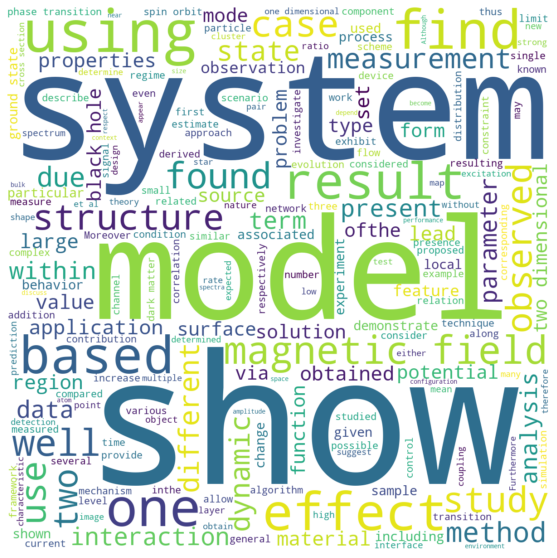

In [49]:
# Word Cloud to visually describe some of the commonly used words in publications
wordcloud = WordCloud(width = 1200, height = 1200, background_color ='white', stopwords = set(STOPWORDS), min_font_size = 10).generate(word_cloud_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

8) Top Unigrams

With Stopwords

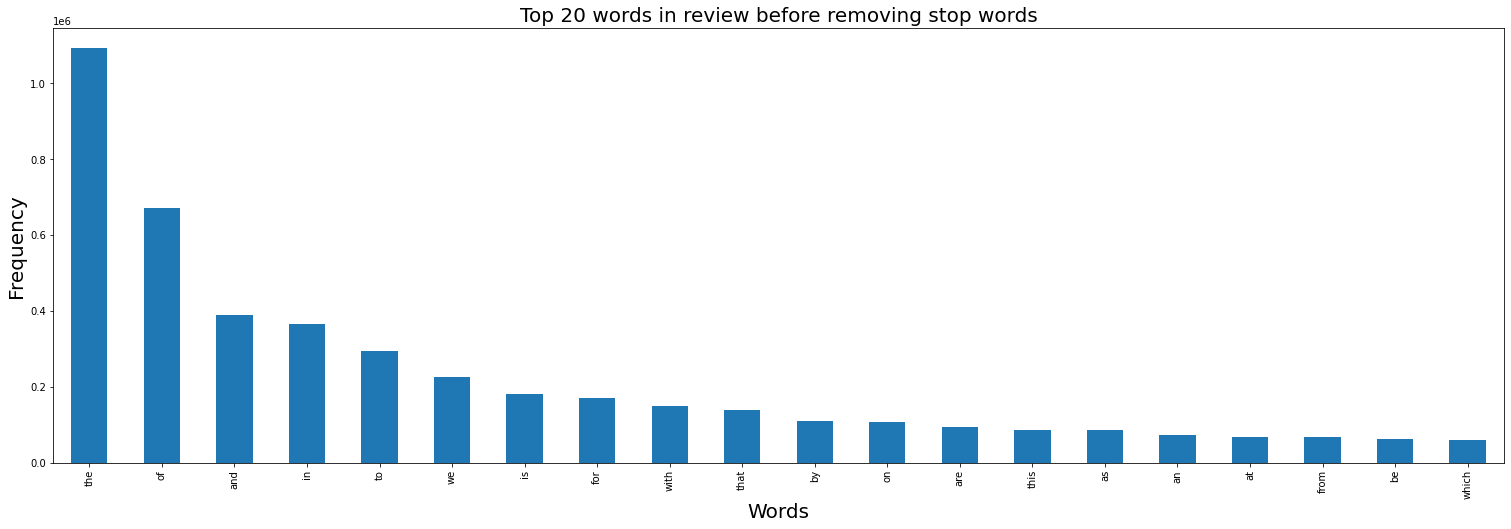

In [50]:
common_words = get_top_n_words(df_10years['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df1.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 words in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

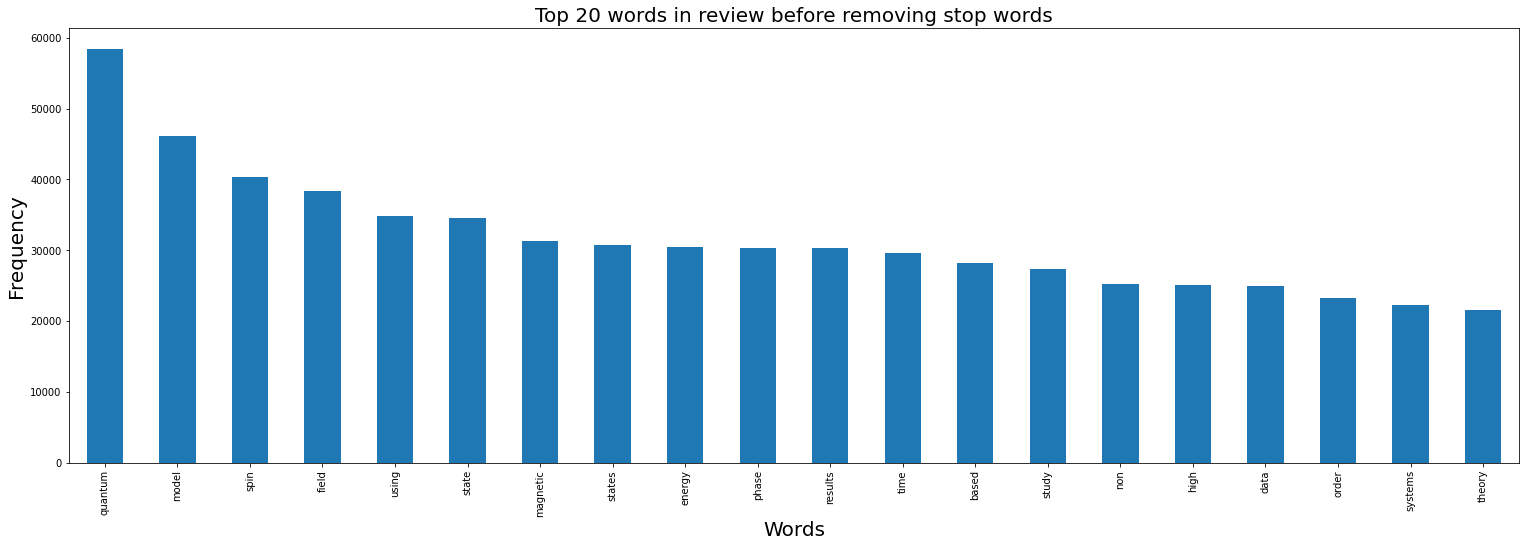

In [51]:
common_words = get_top_n_words_without_stopwords(df_10years['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 words in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

9) Top Bigrams

With Stopwords

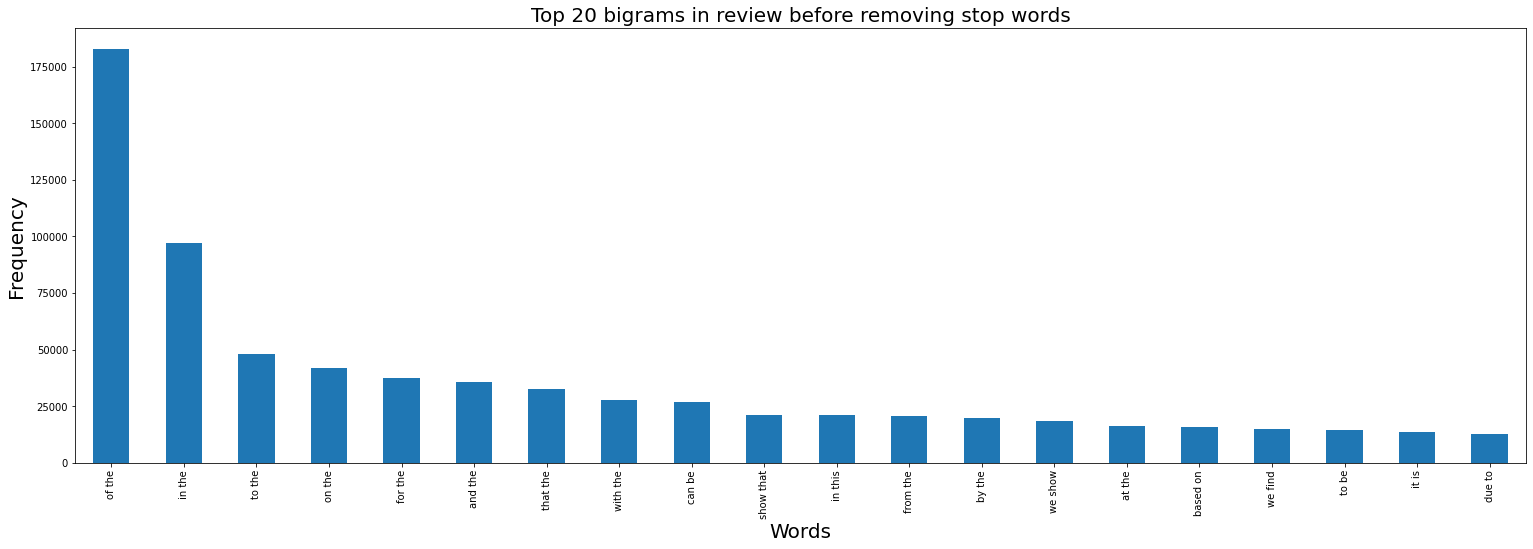

In [52]:
common_words = get_top_n_bigram(df_10years['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 bigrams in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

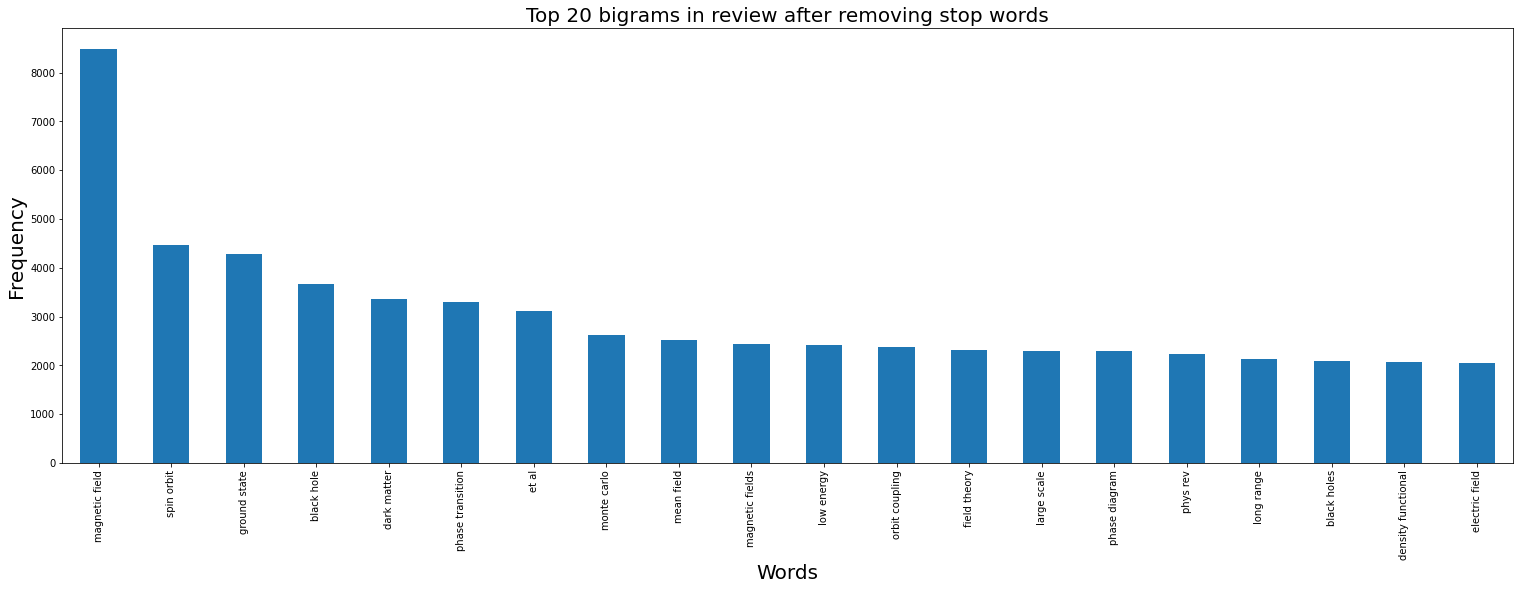

In [53]:
common_words = get_top_n_bigram_without_stopwords(df_10years['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df4.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 bigrams in review after removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

10) Top Trigrams

With Stopwords

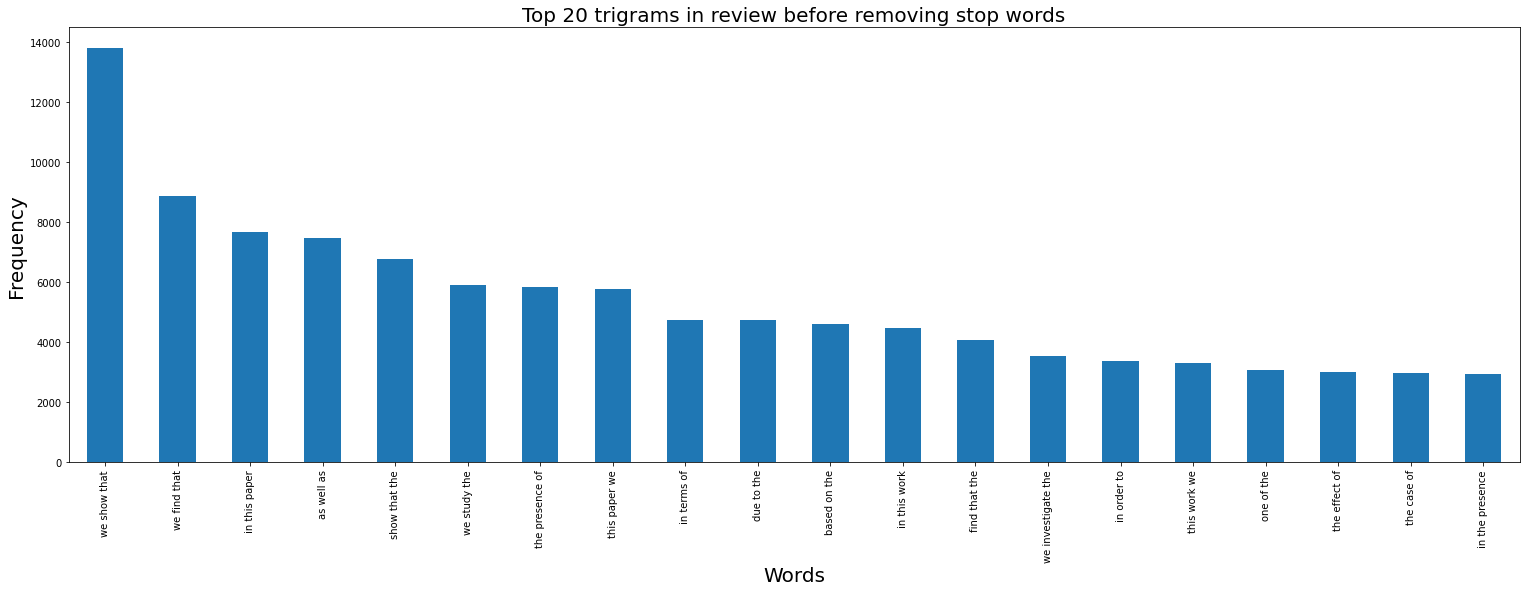

In [54]:
common_words = get_top_n_trigram(df_10years['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df5.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 trigrams in review before removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Without Stopwords

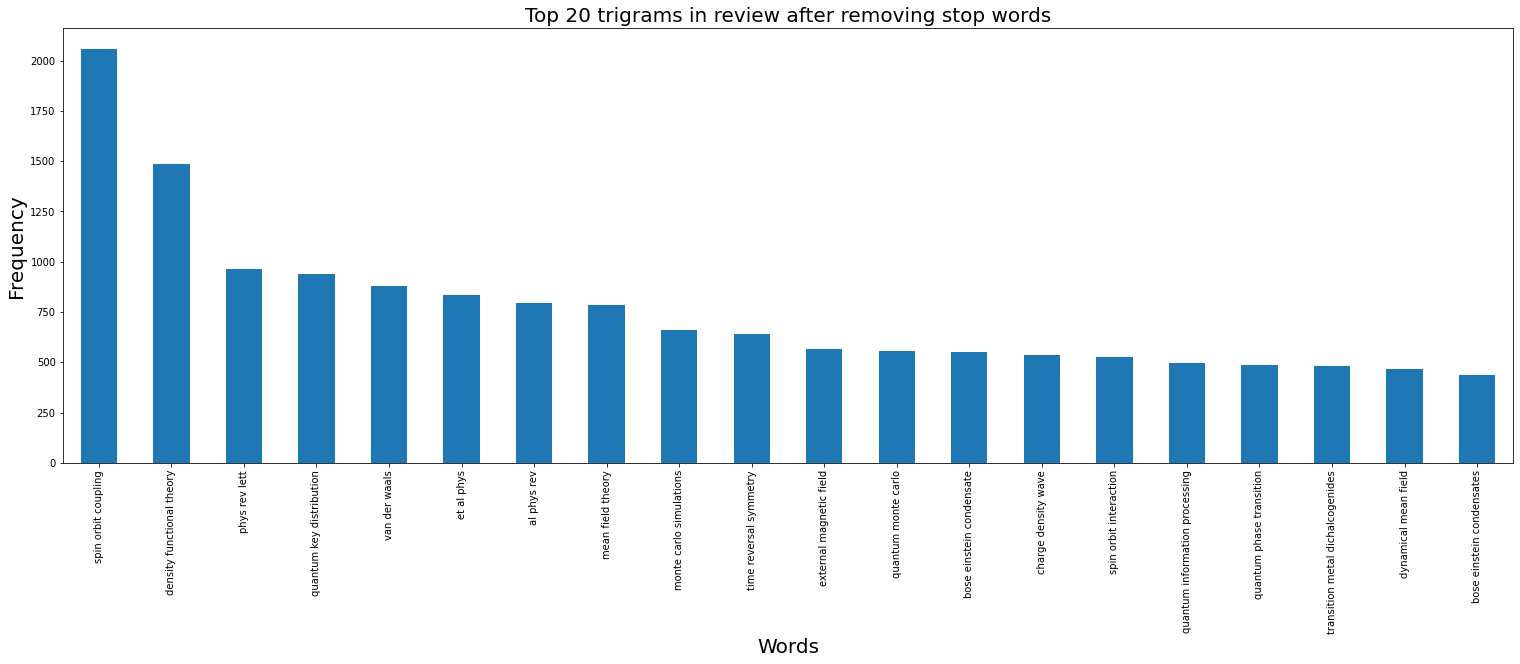

In [55]:
common_words = get_top_n_trigram_without_stopwords(df_10years['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
ax = df6.groupby('text').sum()['count'].sort_values(ascending=False).plot(figsize=(26, 8), kind='bar', title='Top 20 trigrams in review after removing stop words')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

11) Top part-of-speech Tags

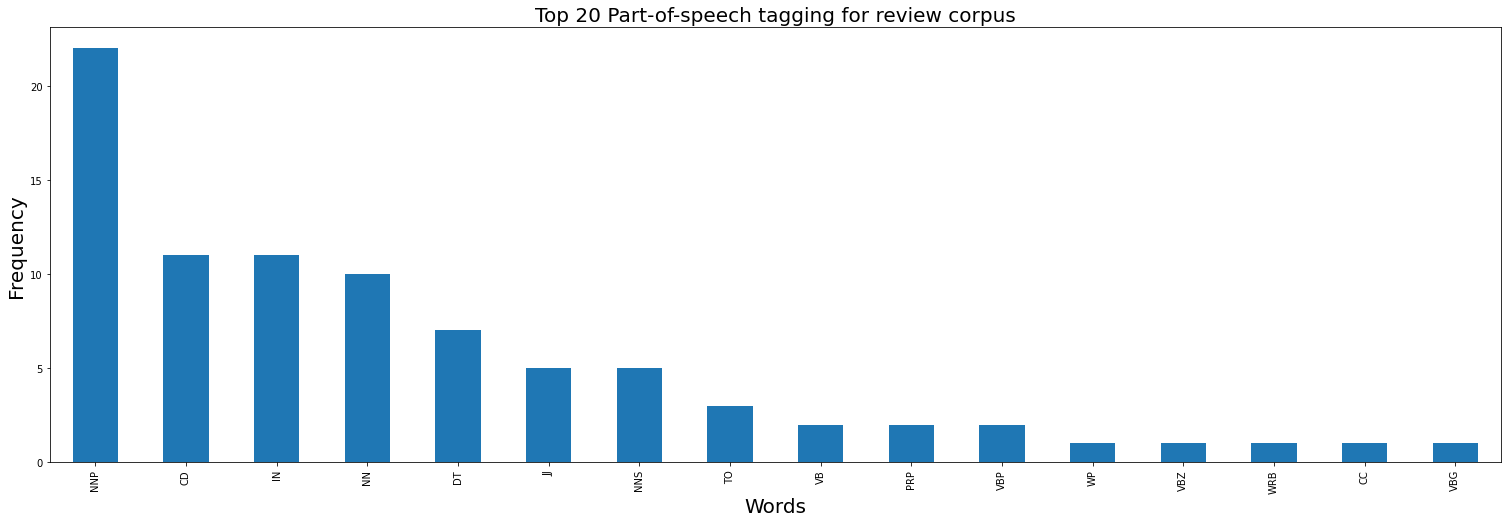

In [56]:
blob = TextBlob(str(df_10years['text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
ax = pos_df.plot(figsize=(26, 8), kind='bar', title='Top 20 Part-of-speech tagging for review corpus')
ax.axes.title.set_size(20)
ax.set_xlabel("Words", fontsize = 20)
ax.set_ylabel("Frequency", fontsize = 20)
plt.show()

Comparison of Class Distributions of 5 year vs 10 year Data

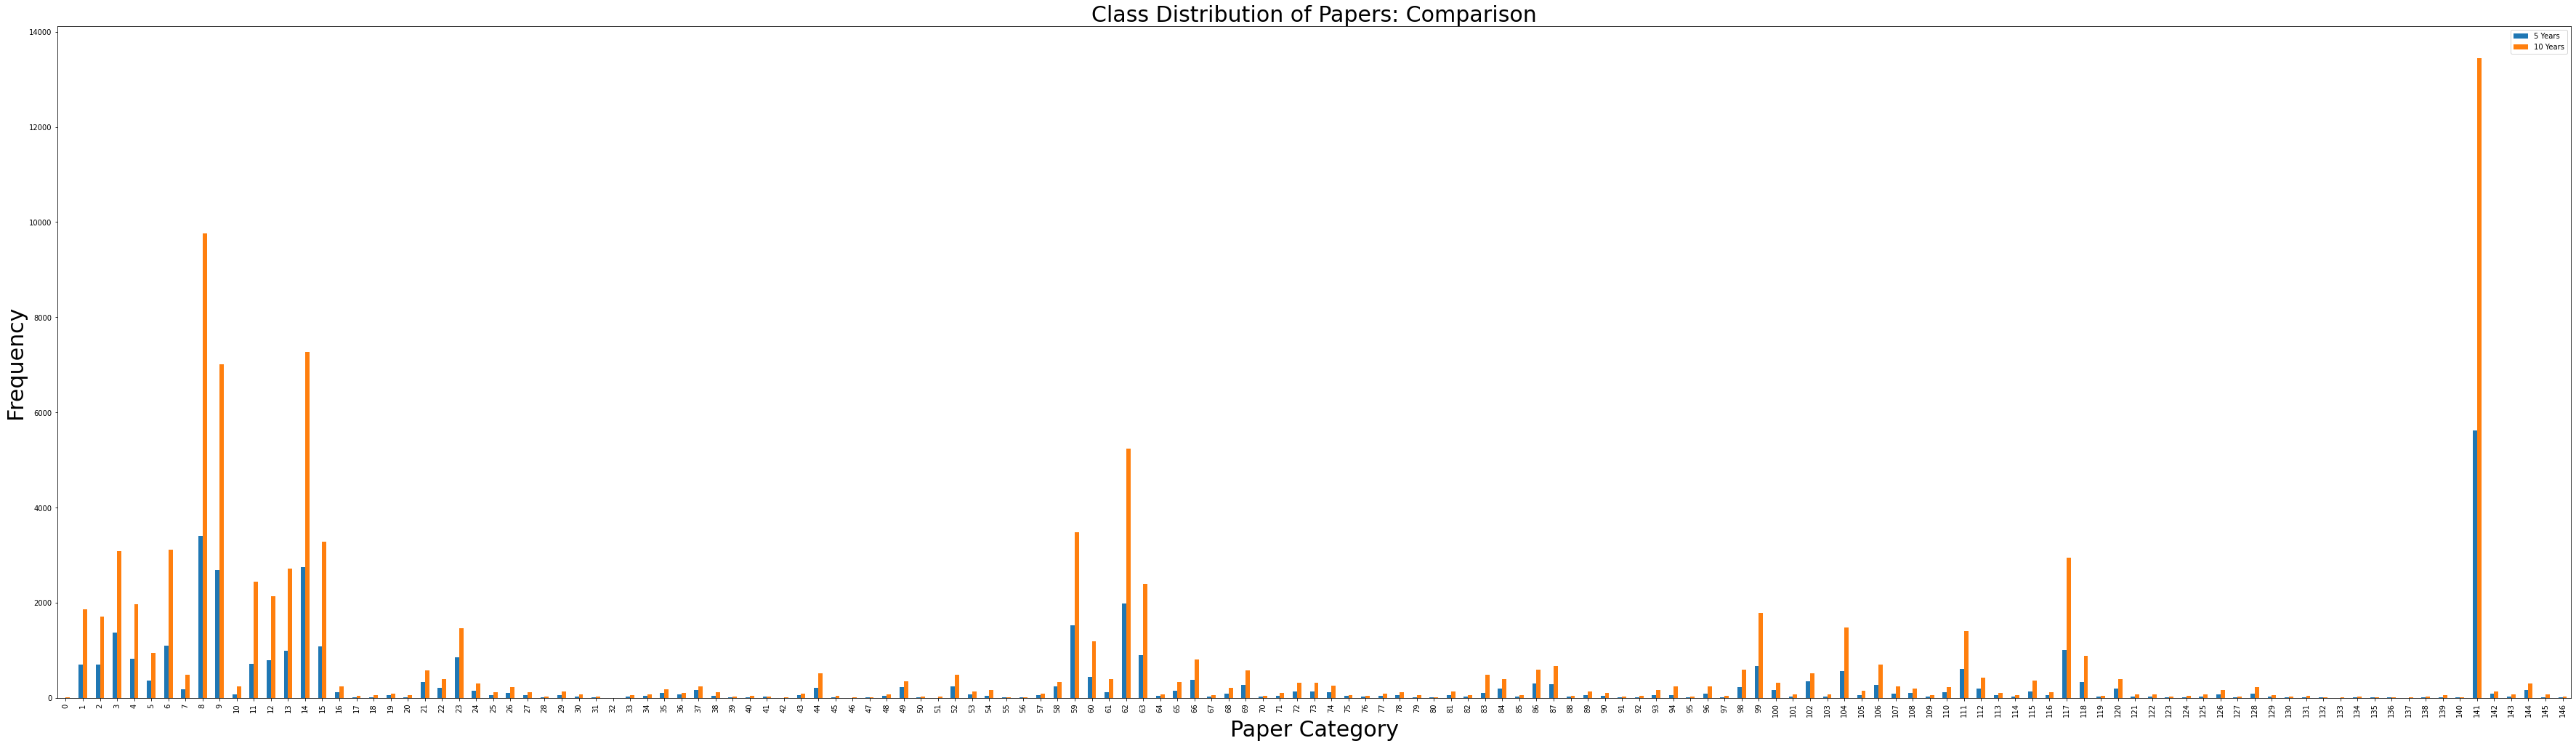

In [57]:
ax = pd.concat({'5 Years': df_5years.groupby("categories_encoded").count()["categories"], '10 Years': df_10years.groupby("categories_encoded").count()["categories"]}, axis=1).plot.bar(figsize=(62, 17), title="Class Distribution of Papers: Comparison")
ax.axes.title.set_size(30)
ax.set_xlabel("Paper Category", fontsize = 30)
ax.set_ylabel("Frequency", fontsize = 30)
plt.show()